In [1]:
from sttn.data.lehd import OriginDestinationEmploymentDataProvider

provider = OriginDestinationEmploymentDataProvider()
state_network = provider.get_data(state='ny', year=2018)

In [ ]:
residence_sum = state_network.agg_adjacent_edges(aggs={'S000':'sum'}, outgoing=False).rename(columns={'S000':'total_jobs'})
with_residence = state_network.join_node_labels(residence_sum)
with_residence.plot(figsize=(15,15), column='total_jobs', cmap="Reds", scheme='quantiles', k=15, legend=True)

<AxesSubplot:>

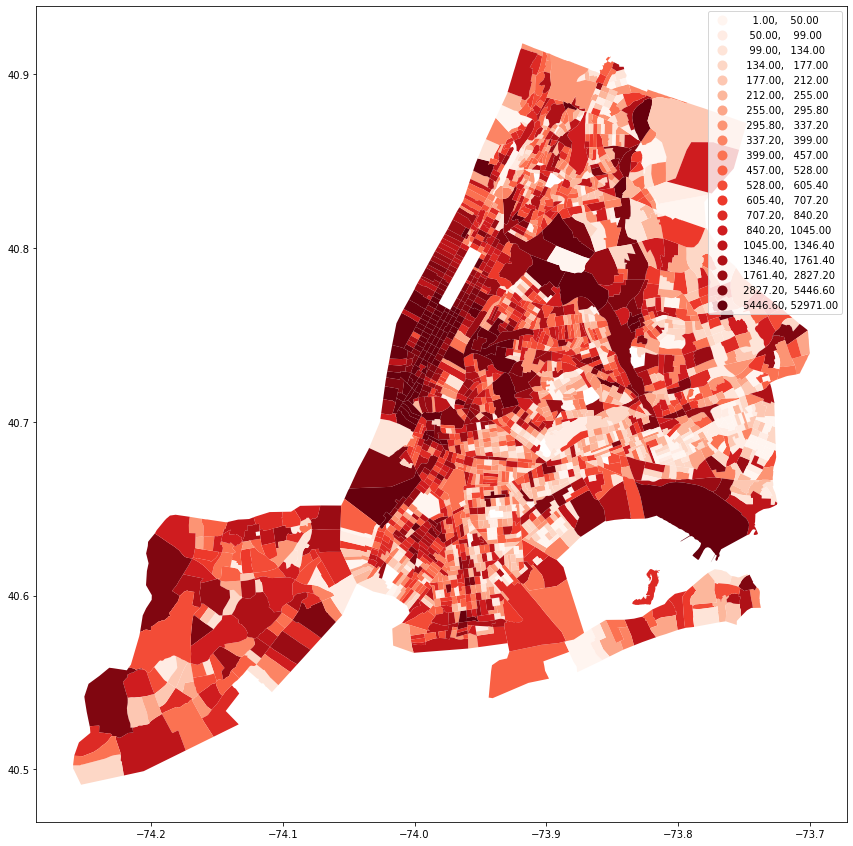

In [5]:
NYC = ['New York County, NY', 'Queens County, NY','Kings County, NY','Bronx County, NY','Richmond County, NY']
bay_area = ['San Francisco County, CA', 'San Mateo County, CA', 'Santa Clara County, CA', 'Alameda County, CA', 'Marin County, CA', 'Contra Costa County, CA']
boston = ['Suffolk County, MA']
phila=['Philadelphia County, PA']
sj = ['Santa Clara County, CA']
sf = ['San Francisco County, CA']
seattle = ['King County, WA']
atlanta = ['Fulton County, GA']
la = ['Los Angeles County, CA']
miami = ['Miami-Dade County, FL']
austin = ['Travis County, TX']
chicago = ['Cook County, IL']
indianapolis = ['Marion County, IN']
portland = ['Multnomah County, OR']
salt_lake = ['Salt Lake County, UT']
vegas = ['Clark County, NV']
detroit = ['Wayne County, MI']
minneapolis = ['Hennepin County, MN']
milwaukee = ['Milwaukee County, WI']
columbus=['Delaware County, OH','Fairfield County, OH', 'Franklin County, OH']
census_network = state_network.filter_nodes(state_network.nodes.county.isin(NYC))
census_network_sum = census_network.agg_adjacent_edges(aggs={'S000':'sum'}, outgoing=False).rename(columns={'S000':'total_jobs'})
census_network_with_residence = census_network.join_node_labels(census_network_sum)
census_network_with_residence.nodes.plot(figsize=(15,15), column='total_jobs', cmap="Reds", scheme='quantiles', k=20, legend=True)

In [17]:
county_network = census_network.group_nodes('zip')
county_network = county_network.agg_parallel_edges(column_aggs={'S000': 'sum', 'SE01': 'sum', 'SE02': 'sum', 'SE03': 'sum'})
#fdf = county_network.to_flow_date_frame(flow='S000')
#fdf.plot_flows(flow_color='red')

In [ ]:
network_with_jobs = compute_jobs(county_network, 'S000')
fdf = network_with_jobs.to_flow_date_frame(flow='S000')
gravity_singly_fitted=fit_gravity_model(fdf, 'power_law')
print(Gravity(gravity_type='singly constrained'))
print(gravity_singly_fitted)
gravity_fdf_fitted = gravity_singly_fitted.generate(network_with_jobs.node_labels.reset_index(),
                                            tile_id_column='id',
                                            tot_outflows_column='outflow',
                                            relevance_column= 'jobs',
                                            out_format='flows').rename(columns={'flow': 'gravity_flow_fitted'})

In [ ]:
compare_performance(fdf, gravity_fdf_fitted)

In [18]:
#county_network.edges['SE01'] = county_network.edges['SE01'] * 2
county_network.edges.sum()

origin         1000110001100011000110001100011000110001100011...
destination    1000110002100031000410005100061000710009100101...
S000                                                     3236414
SE01                                                      607325
SE02                                                      961045
SE03                                                     1668044
dtype: object

In [15]:
extract_model_weights(county_network)

{'SE01': -1.0430371927459576,
 'SE02': -1.012398889533671,
 'SE03': -0.8875562134705136}

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# #, 'Columbus', -0.87, -0.79
cities= [
    'NYC','Phila','San Jose','Atlanta','LA','Miami','SF','Boston','Seattle','Indianapolis','Portland',
    'Salt Lake', 'Las Vegas', 'Detroit', 'Minneapolis', 'Milwaukee' 
]
low = [-1.043, -0.8, -0.87, -0.97, -1.32, -0.91, -0.49, -0.79, -1.15, -0.78, -0.82, -0.77, -0.65, -1.07, -1.06, -0.71]
high = [-0.887, -0.645, -0.67, -0.82, -1.23, -0.75, -0.47, -0.79, -0.97, -0.69, -0.68, -0.54, -0.58, -0.8, -0.76, -0.54]
density = [
    27242.0, 1584064/134, 1927852/1290, 1063937/527, 9818605/4058, 2716940/1899, 805235/47, # SF
    803907/58, 1931249/2116, 964582/396, 735334/431, 1160437/742, 2266715/7891, 1749343/612, # Detroit
    1278869/594, 947735/241, 
]
df = pd.DataFrame({'cities':cities, 'low':low, 'high':high, 'density':density})

#plt.scatter(low, high)
#plt.xlabel("low-income exp")
#plt.ylabel("high-income exp")
#plt.show()
df['high_to_low'] = df.high / df.low
df['high_minus_low'] = df.high - df.low
#df.corr()
df.sort_values('high_minus_low').plot.bar(x='cities', y='high_minus_low', rot=30)

In [ ]:
from sttn.utils import add_distance

dist = add_distance(census_network)
dist_od = add_od_jobs(dist, 'S000')
dist_od.edges_df['coef'] = 1.0* dist_od.edges_df['from_residents']*dist_od.edges_df['to_jobs']
dist_od.edges_df['num'] = dist_od.edges_df['S000']*dist_od.edges_df['coef']
dist_od.edges_df['denum'] = dist_od.edges_df['coef']*dist_od.edges_df['coef']

In [ ]:
bins = list(range(0, 25, 1))
grouped = dist_od.edges_df.groupby(pd.cut(dist_od.edges_df.distance, bins)).sum()[['num', 'denum']]
grouped['fd'] = grouped['num']/grouped['denum']
grouped['fd'].plot(loglog=True,ylabel='f(d)')

In [ ]:
import numpy as np
filtered = dist_od.edges_df[dist_od.edges_df.from_residents > 0].copy()
filtered['ln_coef'] = np.log(filtered['S000']) - np.log(filtered['from_residents']) - np.log(filtered['to_jobs'])
grouped_ln = filtered.groupby(pd.cut(filtered.distance, bins)).mean()[['ln_coef']]
grouped_ln['ln_coef'].plot(ylabel='log(f(d))', logx=True)


In [ ]:
# generate synthetics flows
import numpy as np
np.random.seed(0)

gravity_fdf = Gravity(gravity_type='singly constrained').generate(network_with_jobs.node_labels.reset_index(),
                                            tile_id_column='id',
                                            tot_outflows_column='outflow',
                                            relevance_column= 'jobs',
                                            out_format='flows').rename(columns={'flow': 'gravity_flow'})

gravity_fdf_fitted

In [ ]:
from skmob.models.gravity import compute_distance_matrix
import numpy
import pandas as pd

spatial_tessellation = county_network_with_jobs.node_labels.reset_index()
n_locs = len(spatial_tessellation)
origins = np.arange(n_locs)
distance_matrix = compute_distance_matrix(spatial_tessellation, origins)
spatial_tessellation[['id', 'outflow', 'jobs']].to_csv('~/data/node_descr.csv', index=False)
pd.DataFrame(distance_matrix).to_csv('~/data/distance_matrix.csv', index=False)


In [ ]:
# Radiation model
from skmob.models import Radiation
radiation = Radiation()
np.random.seed(0)

radiation_fdf = radiation.generate(county_network_with_jobs.node_labels.reset_index(), 
                                tile_id_column='id',  
                                tot_outflows_column='outflow', 
                                relevance_column='jobs', 
                                out_format='flows').rename(columns={'flow': 'radiation_flow'})

radiation_fdf

In [10]:
import math
import pandas as pd
from sttn.network import SpatioTemporalNetwork
from sklearn.metrics import mean_squared_error
from skmob.models import Gravity


def fit_gravity_model(fdf, deterrence='power_law'):
    gravity_singly_fitted = Gravity(gravity_type='singly constrained', deterrence_func_type=deterrence)
    gravity_singly_fitted.fit(fdf, relevance_column='jobs')
    return gravity_singly_fitted

def compare_performance(expected_fdf, generated_fdf):
    filtered = expected_fdf[expected_fdf.origin != expected_fdf.destination].rename(columns={'flow': 'flow_expected'})
    merged = filtered.merge(generated_fdf, how='outer', on=['origin', 'destination']).fillna(0)
    
    print(math.sqrt(mean_squared_error(merged.flow_expected,merged.gravity_flow_fitted)))
    print(merged.reset_index()[['flow_expected', 'gravity_flow_fitted']].corr())

def add_od_jobs(network: SpatioTemporalNetwork, job_column: str) -> SpatioTemporalNetwork:
    comp_aggs={job_column: 'sum'}
    jobs = network.agg_adjacent_edges(aggs=comp_aggs, outgoing=False).rename(columns={job_column: 'jobs'})
    residents = network.agg_adjacent_edges(aggs=comp_aggs, outgoing=True).rename(columns={job_column: 'residents'})
    
    mapped_from = network.edges_df.join(residents, on='from').rename(columns={'residents': 'from_residents'})
    mapped_from['from_residents'] = mapped_from['from_residents'].fillna(0)
    mapped_all = mapped_from.join(jobs, on='to').rename(columns={'jobs': 'to_jobs'})
    return SpatioTemporalNetwork(mapped_all, network.node_labels)

def compute_jobs(network, job_column):
    comp_aggs={job_column: 'sum'}
    jobs = network.agg_adjacent_edges(aggs=comp_aggs, outgoing=False).rename(columns={job_column: 'jobs'})
    outflow = network.agg_adjacent_edges(aggs=comp_aggs, outgoing=True, include_cycles=False).rename(columns={job_column: 'outflow'})
    with_jobs = network.join_node_labels(jobs).join_node_labels(outflow)
    return with_jobs

def extract_model_weights(network):
    columns = ['SE01', 'SE02', 'SE03']
    result = {}
    for column in columns:
        with_jobs = compute_jobs(network, column)
        fdf = with_jobs.to_flow_date_frame(flow=column)
        model = fit_gravity_model(fdf)
        result[column] = model.deterrence_func_args[0]
    
    return result

In [ ]:
merged_gravity_comp = nyc_filtered.merge(gravity_fdf_fitted_se01, how='outer', on=['origin', 'destination']).fillna(0)
merged_gravity_comp = merged_gravity_comp.merge(gravity_fdf_fitted_se02, how='outer', on=['origin', 'destination']).fillna(0)
comp = merged_gravity_comp.merge(gravity_fdf_fitted_se03, how='outer', on=['origin', 'destination']).fillna(0)
comp['all'] = comp.gravity_flow_se01 + comp.gravity_flow_se02 + comp.gravity_flow_se03
comp[['flow_expected', 'all']].corr()

In [ ]:
NYC_area = 22.83 + 109 + 70.82 + 42 + 58.5
NYC_population = 1628706 + 2230722 + 2504701 + 1418207 + 476143
NYC_density = NYC_population / NYC_area
NYC_density

In [ ]:
# merged_all.sum()
compression_opts = dict(method='zip',
                        archive_name='nyc_census_tract_flows.csv')
#merged_all.to_csv('~/data/flows_new.csv', index=False)
dist_od.edges_df.sum()
#dist_od.edges_df[['from', 'to', 'S000', 'distance', 'from_residents', 'to_jobs']].to_csv('~/data/nyc_census_tract_flows.zip', index=False, compression=compression_opts)